## 1. Data Collection and Extraction

In [1]:
import csv
import pickle
import random
import shutil

import os
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from utils import *

In [2]:
import numpy as np

data_dir = 'dataset'
seed = 42
w_crop = h_crop = 256
num_classes = 8

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## 2. Exploratory Data Analysis

In [3]:
images_dir = f"{data_dir}/images"
masks_dir = f"{data_dir}/masks"

In [4]:
for path in [images_dir, masks_dir]:
    for dirpath, dirnames, filenames in os.walk(path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}".')

There are 0 directories and 1525 files in "dataset/images".
There are 0 directories and 1525 files in "dataset/masks".


In [5]:
def get_sort_keys(
        filename
):
    splitted_filename = filename.split('.')[0].split('_')
    return splitted_filename[-4], splitted_filename[-3], int(splitted_filename[-2])


def get_sorted_image_paths(
        needed_dir,
        full_path=True
):
    image_paths = sorted(os.listdir(needed_dir), key=get_sort_keys)
    if full_path:
        return [needed_dir + '/' + image_path for image_path in image_paths]
    else:
        return image_paths

In [6]:
image_list = get_sorted_image_paths(images_dir)
print(f'No. of path in the image list: {len(image_list)}')
image_list[:10]

No. of path in the image list: 1525


['dataset/images/d_r_1_.jpg',
 'dataset/images/d_r_3_.jpg',
 'dataset/images/d_r_4_.jpg',
 'dataset/images/d_r_5_.jpg',
 'dataset/images/d_r_14_.jpg',
 'dataset/images/d_r_17_.jpg',
 'dataset/images/d_r_18_.jpg',
 'dataset/images/d_r_20_.jpg',
 'dataset/images/d_r_22_.jpg',
 'dataset/images/d_r_23_.jpg']

In [7]:
mask_list = get_sorted_image_paths(masks_dir)
print(f'No. of path in the image annotation list: {len(mask_list)}')
mask_list[:10]

No. of path in the image annotation list: 1525


['dataset/masks/d_r_1_.bmp',
 'dataset/masks/d_r_3_.bmp',
 'dataset/masks/d_r_4_.bmp',
 'dataset/masks/d_r_5_.bmp',
 'dataset/masks/d_r_14_.bmp',
 'dataset/masks/d_r_17_.bmp',
 'dataset/masks/d_r_18_.bmp',
 'dataset/masks/d_r_20_.bmp',
 'dataset/masks/d_r_22_.bmp',
 'dataset/masks/d_r_23_.bmp']

In [8]:
dataset_dir = 'train_val_dataset'

train_dir = os.path.join(dataset_dir, 'train')
train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')

val_dir = os.path.join(dataset_dir, 'val')
val_images_dir = os.path.join(val_dir, 'images')
val_masks_dir = os.path.join(val_dir, 'masks')

base_aug_transform = A.Compose(
    [
        A.Resize(w_crop, h_crop),
    ], is_check_shapes=False
)

In [ ]:
# Creating training and validation split directories and randomly
for path in [train_images_dir, train_masks_dir, val_images_dir, val_masks_dir]:
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# Zipping image and mask path and shuffling the list
path_list = list(zip(image_list, mask_list))
random.shuffle(path_list)

train_size = int(len(image_list) * 0.8)

# Moving the images and mask images in their split directory.
loop = tqdm(enumerate(path_list), total=len(path_list))
for i, (img_path, mask_path) in loop:
    if not img_path.split('/')[-1].split('.')[0] == mask_path.split('/')[-1].split('.')[0]:
        print(f'[ERROR] Image and Mask file do not match, check the path list at index {i}.')
        break

    if not os.path.isfile(img_path) or not os.path.isfile(mask_path):
        print(f'[ERROR] File does not exist: {img_path} and {mask_path}')

    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
    transformed = base_aug_transform(image=image, mask=mask)

    final_images_dir = train_images_dir if i < train_size else val_images_dir
    final_masks_dir = train_masks_dir if i < train_size else val_masks_dir
    cv2.imwrite(
        os.path.join(final_images_dir, img_path.split('/')[-1]),
        cv2.cvtColor(transformed['image'], cv2.COLOR_BGR2RGB)
    )
    cv2.imwrite(
        os.path.join(final_masks_dir, mask_path.split('/')[-1]),
        cv2.cvtColor(transformed['mask'], cv2.COLOR_BGR2RGB)
    )

print('[INFO]: Dataset is been splitted into train and val directory.')

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1, [diffX // 2, diffX - diffX // 2,
                 diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        super().__init__(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=dilation,
                dilation=dilation,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        )

        rate1, rate2, rate3 = tuple(atrous_rates)

        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


class DeepLabV3Decoder(nn.Sequential):
    def __init__(self, in_channels, out_channels=256, atrous_rates=(12, 24, 36)):
        super().__init__(
            ASPP(in_channels, out_channels, atrous_rates),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.out_channels = out_channels

    def forward(self, *features):
        return super().forward(features[-1])


class SegmentationHead(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling, nn.Identity())


from torchvision import models
import torch.utils.model_zoo as model_zoo


class ResNetEncoder(models.resnet.ResNet):
    _output_stride = 32

    @property
    def out_channels(self):
        return self._out_channels[: self._depth + 1]

    @property
    def output_stride(self):
        return min(self._output_stride, 2 ** self._depth)

    def make_dilated(self, output_stride):
        if output_stride == 8:
            stage_list = [4, 5]
            dilation_list = [2, 4]
        else:
            raise ValueError("Output stride should be 8, got {}.".format(output_stride))

        self._output_stride = output_stride

        stages = self.get_stages()
        for stage_indx, dilation_rate in zip(stage_list, dilation_list):
            for mod in stages[stage_indx].modules():
                if isinstance(mod, nn.Conv2d):
                    mod.stride = (1, 1)
                    mod.dilation = (dilation_rate, dilation_rate)
                    kh, kw = mod.kernel_size
                    mod.padding = ((kh // 2) * dilation_rate, (kh // 2) * dilation_rate)

    def __init__(self, out_channels, depth=5, **kwargs):
        super().__init__(**kwargs)
        self._depth = depth
        self._out_channels = out_channels
        self._in_channels = 3

        del self.fc
        del self.avgpool

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self.conv1, self.bn1, self.relu),
            nn.Sequential(self.maxpool, self.layer1),
            self.layer2,
            self.layer3,
            self.layer4,
        ]

    def forward(self, x):
        stages = self.get_stages()

        features = []
        for i in range(self._depth + 1):
            x = stages[i](x)
            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("fc.bias", None)
        state_dict.pop("fc.weight", None)
        super().load_state_dict(state_dict, **kwargs)


class DeepLabV3(nn.Module):
    def __init__(
            self,
            decoder_channels: int = 256,
            n_classes: int = 1,
            upsampling: int = 8,
    ):
        super().__init__()

        encoder = ResNetEncoder(
            out_channels=(3, 64, 64, 128, 256, 512),
            block=models.resnet.BasicBlock,
            layers=[3, 4, 6, 3],
        )

        encoder.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
        encoder.make_dilated(8)

        self.encoder = encoder

        self.decoder = DeepLabV3Decoder(
            in_channels=self.encoder.out_channels[-1],
            out_channels=decoder_channels,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=self.decoder.out_channels,
            out_channels=n_classes,
            kernel_size=1,
            upsampling=upsampling,
        )

    def check_input_shape(self, x):
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (h // output_stride + 1) * output_stride if h % output_stride != 0 else h
            new_w = (w // output_stride + 1) * output_stride if w % output_stride != 0 else w
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        self.check_input_shape(x)

        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        return masks

    @torch.no_grad()
    def predict(self, x):
        if self.training:
            self.eval()

        x = self.forward(x)

        return x

In [11]:
# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=False):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear
# 
#         self.inc = (DoubleConv(n_channels, 64))
#         self.down1 = (Down(64, 128))
#         self.down2 = (Down(128, 256))
#         self.down3 = (Down(256, 512))
#         factor = 2 if bilinear else 1
#         self.down4 = (Down(512, 1024 // factor))
#         self.up1 = (Up(1024, 512 // factor, bilinear))
#         self.up2 = (Up(512, 256 // factor, bilinear))
#         self.up3 = (Up(256, 128 // factor, bilinear))
#         self.up4 = (Up(128, 64, bilinear))
#         self.outc = (OutConv(64, n_classes))
# 
#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits
# 
#     def use_checkpointing(self):
#         self.inc = torch.utils.checkpoint(self.inc)
#         self.down1 = torch.utils.checkpoint(self.down1)
#         self.down2 = torch.utils.checkpoint(self.down2)
#         self.down3 = torch.utils.checkpoint(self.down3)
#         self.down4 = torch.utils.checkpoint(self.down4)
#         self.up1 = torch.utils.checkpoint(self.up1)
#         self.up2 = torch.utils.checkpoint(self.up2)
#         self.up3 = torch.utils.checkpoint(self.up3)
#         self.up4 = torch.utils.checkpoint(self.up4)
#         self.outc = torch.utils.checkpoint(self.outc)

In [12]:
# # Performing a unit test to check whether the model works or not
# x = torch.randn((3, 3, 256, 256))
# model = UNet(n_classes=num_classes)
# output = model(x)
# assert x.shape[2:] == output.shape[2:]
# print(f'Input shape: {x.shape} and output shape: {output.shape}')

## Dataset and DataLoader Preparation

Now that we have the data and model ready to work on, we can proceed with the next step, that is data preparation, here we will build our dataset that can be feeded into the model, this will be done using the PyTorch dataset generating and loading method.

In [13]:
# Getting the mask colors for all the classes from the csv file
classes_csvpath = 'dataset/classes.csv'
classes_colormap = {}
classes = []

with open(classes_csvpath, 'r') as file:
    reader = csv.DictReader(file)
    for i, data in enumerate(reader):
        classes_colormap[data['name']] = ((int(data['r']),
                                           int(data['g']),
                                           int(data['b'])))
        classes.append(data['name'])
print('Classes:\n', classes, '\nColormap:\n', classes_colormap, '\nClasses length:', len(classes))

Classes:
 ['background', 'divers', 'plants', 'ruins', 'robots', 'reefs', 'fish', 'rocks'] 
Colormap:
 {'background': (0, 0, 0), 'divers': (0, 0, 1), 'plants': (0, 1, 0), 'ruins': (0, 1, 1), 'robots': (1, 0, 0), 'reefs': (1, 0, 1), 'fish': (1, 1, 0), 'rocks': (1, 1, 1)} 
Classes length: 8


In [14]:
# Creating the dataset class
class CustomDataset(Dataset):
    def __init__(
            self,
            img_dir: str,
            mask_dir: str,
            colormap: list,
            transform=None
    ):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.colormap = colormap
        self.transform = transform

        # Getting all the path of images and masks
        self.path_list = get_sorted_image_paths(img_dir, False)

    def rgbmask_to_label(
            self,
            rgb_mask: np.ndarray,
            colormap: list
    ):
        # A array to fill the output later.
        output = np.zeros(rgb_mask.shape[:2])

        new_rgb_mask = rgb_mask / 255
        new_rgb_mask[new_rgb_mask >= 0.5] = 1
        new_rgb_mask[new_rgb_mask < 0.5] = 0

        for label, color in enumerate(colormap):
            output[np.all(np.equal(new_rgb_mask, color), axis=-1)] = label

        return output

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, index):
        # Getting the path of image and mask
        image_path = os.path.join(self.img_dir, self.path_list[index])
        mask_path = os.path.join(self.mask_dir, self.path_list[index].replace('.jpg', '.bmp'))

        # Reading the image and mask file in RGB format
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

        # Transforming the image and masks using augmentation
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        # Transforming the mask into label encoded format
        mask = mask.detach().numpy() if type(mask) == torch.Tensor else mask
        mask = self.rgbmask_to_label(rgb_mask=mask, colormap=self.colormap)
        mask = torch.from_numpy(mask).type(torch.LongTensor)
        return image, mask

In [15]:
dataset = CustomDataset(
    img_dir=train_images_dir,
    mask_dir=train_masks_dir,
    colormap=classes_colormap.values()
)

Size of the dataset: 1220
Shape of Image: (256, 256, 3) and mask: torch.Size([256, 256])
Classes in the mask images: [0 3 5 6 7]

Plotting the data:


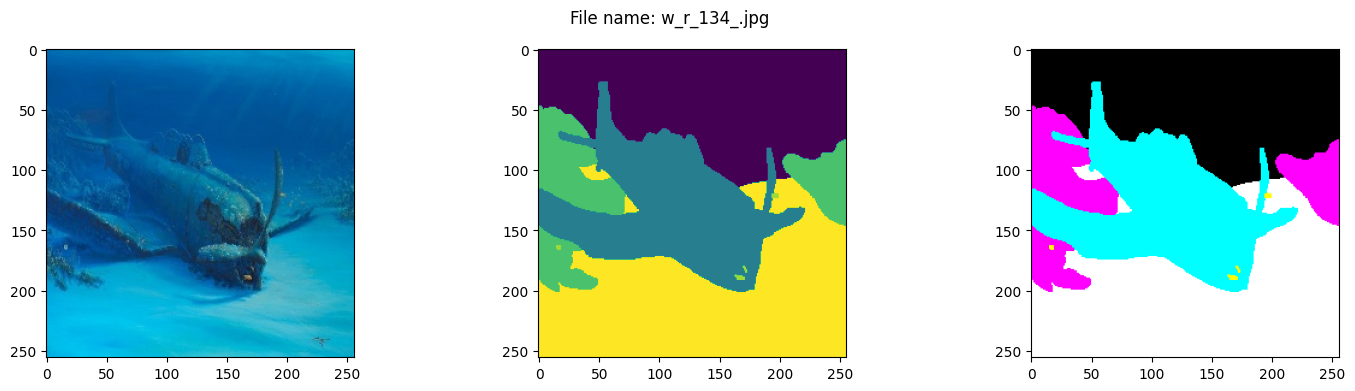

In [16]:
# Testing the PyTorch dataset class on random index
rand_num = np.random.randint(len(dataset))
image, mask = dataset[rand_num]

print(f'Size of the dataset: {len(dataset)}')
print(f'Shape of Image: {image.shape} and mask: {mask.shape}')
print(f'Classes in the mask images: {np.unique(mask)}')
print('\nPlotting the data:')

filename = dataset.path_list[rand_num]
plt.figure(figsize=(18, 4))
plt.suptitle(f'File name: {filename}')
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(mask)
plt.subplot(133)
plt.imshow(plt.imread(os.path.join(dataset.mask_dir, filename.replace('.jpg', '.bmp'))));

In [17]:
# Building a function that creates and provides dataloaders
def get_dataloaders(
        img_dir: str,
        mask_dir: str,
        colormap: list,
        batch_size: int,
        num_workers: int,
        transform=None,
        shuffle: bool = True,
        pin_memory: bool = True
):
    # Getting the dataset
    dataset = CustomDataset(
        img_dir=img_dir,
        mask_dir=mask_dir,
        colormap=colormap,
        transform=transform
    )

    # Creating dataloaders
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True
    )

    return dataloader

## Model Training

Now, that we have the model and dataset ready, we can fit the dataset in the model and train the model.

Note - While getting the dataset, we have an option to perform online augmentation on the data, in this case we will be performing resize, normalization and changing the format to a PyTorch tensor, our dataset contains original and augmented images already any more augmentation can give us an unexpected result.

In [18]:
# Creating a function to calculate accuracy and DICE metrics while training the model
def calculate_accuracy(
        pred: torch.Tensor,
        target: torch.Tensor
):
    assert len(pred.shape) == 4 and len(target.shape) == 3
    pred = nn.Softmax2d()(pred).argmax(1).int()
    target = target.int()
    return ((pred == target).sum() / torch.numel(target)).item()


def calculate_iou_dice(
        pred: torch.Tensor,
        target: torch.Tensor,
        n_classes: int
):
    assert len(pred.shape) == 4 and len(target.shape) == 3
    assert pred.shape[1] == n_classes
    dice_array = []
    iou_array = []

    # Getting the predicted labels for every pixel
    # Flattening both the predicted and groundtruth tensor
    pred = nn.Softmax2d()(pred).argmax(dim=1).view(-1)
    target = target.view(-1)

    # Looping through the data for each class and
    # calculating the DICE and Iou score
    for class_idx in range(n_classes):

        # Creating a tensor for matching classes
        pred_inds = pred == class_idx
        target_inds = target == class_idx

        # Calculating the IoU score
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() \
                + target_inds.long().sum().item() - intersection

        # Stopping the zero error for division
        if union == 0:
            iou = 0
            iou_array.append(iou)
            dice_array.append(iou)
        else:
            iou = intersection / union
            iou_array.append(iou)

            # Calculating the dice score
            dice = (2 * iou) / (iou + 1)
            dice_array.append(dice)

    # Getting the average of both the scores
    iou_mean = np.mean(iou_array)
    dice_mean = np.mean(dice_array)

    return iou_mean, dice_mean, iou_array

In [19]:
# Function for saving and loading model checkpoint
def save_model_checkpoint(
        model,
        optimizer,
        dir_path='model',
        filename: str = 'model_checkpoint.pth'
):
    assert filename.split('.')[-1] in ['pt', 'pth'], \
        '[ERROR] filename extension must be either "pt" or "pth".'

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    obj_dict = {'model_state_dict': model.state_dict(),
                'optim_state_dict': optimizer.state_dict()}
    torch.save(obj_dict, os.path.join(dir_path, filename))

    print(
        f'[INFO] Checkpoint has been saved to the location:' \
        f'"{os.path.join(dir_path, filename)}".'
    )


def load_model_checkpoint(
        model,
        checkpoint_filepath: str = 'model_checkpoint.pth',
        device=None
):
    assert checkpoint_filepath.split('.')[-1] in ['pt', 'pth'], \
        '[ERROR] filename extension must be either "pt" or "pth".'

    if not os.path.isfile(checkpoint_filepath):
        raise Exception(f'[ERROR] File "{checkpoint_filepath}" does not exists.')

    print(f'[INFO] Loading model from checkpoint location: "{checkpoint_filepath}".')

    obj_dict = torch.load(
        checkpoint_filepath,
        map_location=device
    )

    model.load_state_dict(obj_dict['model_state_dict'])

In [20]:
# Writing the training and testing step function
def train_step(
        model,
        checkpoint_dir,
        checkpoint_filename,
        dataloader,
        loss_fn,
        optimizer,
        scaler,
        n_classes,
        device
):
    train_loss = 0
    train_acc = 0
    train_dice_mean = 0
    train_iou_mean = 0

    # Setting the model in training mode
    model.train()

    with tqdm(dataloader, unit='batch', ) as tqdm_train_loader:
        for batch_idx, (input_images, target_masks) in enumerate(
                tqdm_train_loader,
                start=1
        ):
            tqdm_train_loader.set_description(desc='Train Batch')

            # Putting the data in torch device
            input_images = input_images.to(device=device)
            target_masks = target_masks.long().to(device=device)

            # Forward propagation
            with torch.cuda.amp.autocast():
                pred_outputs = model(input_images.float())
                loss = loss_fn(pred_outputs, target_masks)

            # Backward propagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Updating the training metric
            train_loss += loss.item()
            train_acc += calculate_accuracy(
                pred=pred_outputs,
                target=target_masks
            )
            iou_mean, dice_mean, _ = calculate_iou_dice(
                pred=pred_outputs,
                target=target_masks,
                n_classes=n_classes
            )

            train_iou_mean += iou_mean
            train_dice_mean += dice_mean

    # Saving the model checkpoint
    save_model_checkpoint(
        model=model,
        optimizer=optimizer,
        dir_path=checkpoint_dir,
        filename=checkpoint_filename
    )

    # Averaging the loss
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_iou_mean /= len(dataloader)
    train_dice_mean /= len(dataloader)

    return train_loss, train_acc, train_iou_mean, train_dice_mean


@torch.inference_mode()
def test_step(
        model,
        dataloader,
        loss_fn,
        n_classes,
        device
):
    test_loss = 0
    test_acc = 0
    test_dice_mean = 0
    test_iou_mean = 0
    test_pixel_acc_mean = 0

    all_iou_classes = []

    # Setting the model in evaluation mode
    model.eval()
    with tqdm(dataloader, unit='batch', ) as tqdm_test_loader:
        for batch_idx, (input_images, target_masks) in enumerate(
                tqdm_test_loader,
                start=1
        ):
            tqdm_test_loader.set_description(desc='Val/Test Batch')

            # Putting the data in torch device
            input_images = input_images.to(device=device)
            target_masks = target_masks.long().to(device=device)

            # Forward propogation
            with torch.cuda.amp.autocast():
                pred_outputs = model(input_images.float())
                loss = loss_fn(pred_outputs, target_masks)

            # Updating the training metric
            test_loss += loss.item()
            test_acc += calculate_accuracy(
                pred=pred_outputs,
                target=target_masks
            )
            iou_mean, dice_mean, iou_classes = calculate_iou_dice(
                pred=pred_outputs,
                target=target_masks,
                n_classes=n_classes
            )
            test_iou_mean += iou_mean
            test_dice_mean += dice_mean
            all_iou_classes.append(iou_classes)

    # Averaging the loss
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    test_iou_mean /= len(dataloader)
    test_dice_mean /= len(dataloader)

    return test_loss, test_acc, test_iou_mean, test_dice_mean, np.mean(all_iou_classes, axis=0)


# Function to train the model using the above train and test steps
def model_training(
        model,
        checkpoint_dir,
        checkpoint_filename,
        train_loader,
        test_loader,
        loss_fn,
        optimizer,
        scaler,
        n_classes,
        epochs,
        device
):
    # Creating a dict to store all the metric result
    results = {
        'train_loss': [],
        'train_acc': [],
        'train_iou_mean': [],
        'train_dice_mean': [],
        'test_loss': [],
        'test_acc': [],
        'test_iou_mean': [],
        'test_dice_mean': [],
    }

    # Train and eval/test loop
    for epoch in tqdm(range(epochs), desc='Epoch'):
        torch.cuda.empty_cache()
        # Model training
        (train_loss, train_acc, train_iou_mean,
         train_dice_mean) = train_step(
            model=model,
            checkpoint_dir=checkpoint_dir,
            checkpoint_filename=checkpoint_filename,
            dataloader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scaler=scaler,
            n_classes=n_classes,
            device=device
        )

        # Model testing
        (test_loss, test_acc, test_iou_mean,
         test_dice_mean, test_iou_classes) = test_step(
            model=model,
            dataloader=test_loader,
            loss_fn=loss_fn,
            n_classes=n_classes,
            device=device
        )

        print(
            f'Epoch: {epoch + 1} | Train Loss: {train_loss:.3f},'
            f' Train Accuracy: {train_acc:.3f}, Train IoU Mean: {train_iou_mean:.3f},'
            f' Train DICE Mean: {train_dice_mean:.3f} |'
        )
        print(
            f'Epoch: {epoch + 1} | Test Loss: {test_loss:.3f},'
            f' Test Accuracy: {test_acc:.3f}, Test IoU Mean: {test_iou_mean:.3f},'
            f' Test DICE Mean: {test_dice_mean:.3f}, Test IoU Classes: {np.array2string(np.round(test_iou_classes, 2), precision=2)} |'
        )

        # Storing every epoch result in the result dict.
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['train_iou_mean'].append(train_iou_mean)
        results['train_dice_mean'].append(train_dice_mean)

        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_iou_mean'].append(test_iou_mean)
        results['test_dice_mean'].append(test_dice_mean)

    return results

In [21]:
# Creating the transform for the dataset
def get_train_transform(
        img_height: int,
        img_width: int,
        norm_mean: list,
        norm_std: list
):
    return A.Compose(
        [
            A.Resize(img_height, img_width),
            A.Normalize(
                mean=norm_mean,
                std=norm_std
            ),
            ToTensorV2()
        ]
    )


def get_test_transform(
        img_height: int,
        img_width: int,
        norm_mean: list,
        norm_std: list
):
    return A.Compose(
        [
            A.Resize(img_height, img_width),
            A.Normalize(
                mean=norm_mean,
                std=norm_std
            ),
            ToTensorV2()
        ]
    )

### Baseline Model

In our baseline model training we will be using the original dataset only with a limit of 50% on the training dataset and data augmentation while training the model.

In [24]:
# Setting Hyperparameters and constant variables
# Training data
TRAIN_IMG_DIR = 'train_val_dataset/train/images'
TRAIN_MASK_DIR = 'train_val_dataset/train/masks'
VAL_IMG_DIR = 'train_val_dataset/val/images'
VAL_MASK_DIR = 'train_val_dataset/val/masks'
COLORMAP_LIST = list(classes_colormap.values())

# Transform data
IMG_HEIGHT = h_crop
IMG_WIDTH = w_crop
NORM_MEAN = [0.0, 0.0, 0.0]
NORM_STD = [1.0, 1.0, 1.0]

# Training hyperparameters
BATCH_SIZE = 16
NUM_WORKERS = 0
SHUFFLE = False
PIN_MEMORY = True
LEARNING_RATE = 5e-3
NUM_EPOCHS = 20
NUM_CLASSES = len(COLORMAP_LIST)
LOAD_MODEL = False

In [25]:
# Setting up model training
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

model = DeepLabV3(n_classes=8).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

# Getting transform for augmenting data while training
train_transform = get_train_transform(
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    norm_mean=NORM_MEAN,
    norm_std=NORM_STD
)

val_transform = get_test_transform(
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    norm_mean=NORM_MEAN,
    norm_std=NORM_STD
)

# Creating train and val dataloaders
train_dataloader = get_dataloaders(
    img_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    colormap=COLORMAP_LIST,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=train_transform,
    shuffle=SHUFFLE,
    pin_memory=PIN_MEMORY
)

val_dataloader = get_dataloaders(
    img_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    colormap=COLORMAP_LIST,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=train_transform,
    shuffle=SHUFFLE,
    pin_memory=PIN_MEMORY
)

# Loading the model if there's any checkpoint
if LOAD_MODEL:
    load_model_checkpoint(
        model=model,
        checkpoint_filepath='model/model0_checkpoint.pth'
    )

# Performing model training - Model0
model0_result = model_training(
    model=model,
    checkpoint_dir='model',
    checkpoint_filename='model0_checkpoint.pth',
    train_loader=train_dataloader,
    test_loader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scaler=scaler,
    n_classes=NUM_CLASSES,
    epochs=NUM_EPOCHS,
    device=DEVICE
)

with open('model/model0.pkl', 'wb') as f:
    pickle.dump({'result': model0_result}, f)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 1 | Train Loss: 1.539, Train Accuracy: 0.501, Train IoU Mean: 0.357, Train DICE Mean: 0.159 |
Epoch: 1 | Test Loss: 1.337, Test Accuracy: 0.604, Test IoU Mean: 0.272, Test DICE Mean: 0.221, Test IoU Classes: [0.69 0.19 0.15 0.14 0.05 0.62 0.19 0.17] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 2 | Train Loss: 1.150, Train Accuracy: 0.631, Train IoU Mean: 0.388, Train DICE Mean: 0.233 |
Epoch: 2 | Test Loss: 1.158, Test Accuracy: 0.644, Test IoU Mean: 0.335, Test DICE Mean: 0.273, Test IoU Classes: [0.71 0.17 0.22 0.08 0.23 0.68 0.31 0.27] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 3 | Train Loss: 1.023, Train Accuracy: 0.673, Train IoU Mean: 0.308, Train DICE Mean: 0.288 |
Epoch: 3 | Test Loss: 1.073, Test Accuracy: 0.667, Test IoU Mean: 0.338, Test DICE Mean: 0.296, Test IoU Classes: [0.82 0.11 0.04 0.3  0.08 0.59 0.36 0.41] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 4 | Train Loss: 0.948, Train Accuracy: 0.695, Train IoU Mean: 0.521, Train DICE Mean: 0.311 |
Epoch: 4 | Test Loss: 1.027, Test Accuracy: 0.680, Test IoU Mean: 0.376, Test DICE Mean: 0.309, Test IoU Classes: [0.82 0.2  0.17 0.21 0.03 0.76 0.38 0.43] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 5 | Train Loss: 0.893, Train Accuracy: 0.712, Train IoU Mean: 0.342, Train DICE Mean: 0.326 |
Epoch: 5 | Test Loss: 0.995, Test Accuracy: 0.689, Test IoU Mean: 0.358, Test DICE Mean: 0.317, Test IoU Classes: [0.78 0.08 0.17 0.26 0.2  0.61 0.37 0.4 ] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 6 | Train Loss: 0.844, Train Accuracy: 0.728, Train IoU Mean: 0.503, Train DICE Mean: 0.339 |
Epoch: 6 | Test Loss: 0.971, Test Accuracy: 0.696, Test IoU Mean: 0.377, Test DICE Mean: 0.323, Test IoU Classes: [0.83 0.07 0.14 0.17 0.2  0.67 0.39 0.55] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 7 | Train Loss: 0.799, Train Accuracy: 0.743, Train IoU Mean: 0.510, Train DICE Mean: 0.351 |
Epoch: 7 | Test Loss: 0.951, Test Accuracy: 0.702, Test IoU Mean: 0.414, Test DICE Mean: 0.329, Test IoU Classes: [0.81 0.15 0.13 0.37 0.2  0.73 0.43 0.49] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 8 | Train Loss: 0.757, Train Accuracy: 0.758, Train IoU Mean: 0.571, Train DICE Mean: 0.364 |
Epoch: 8 | Test Loss: 0.934, Test Accuracy: 0.708, Test IoU Mean: 0.354, Test DICE Mean: 0.337, Test IoU Classes: [0.87 0.11 0.09 0.22 0.03 0.66 0.41 0.44] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 9 | Train Loss: 0.718, Train Accuracy: 0.772, Train IoU Mean: 0.394, Train DICE Mean: 0.377 |
Epoch: 9 | Test Loss: 0.922, Test Accuracy: 0.713, Test IoU Mean: 0.441, Test DICE Mean: 0.347, Test IoU Classes: [0.8  0.23 0.19 0.32 0.22 0.71 0.52 0.55] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 10 | Train Loss: 0.682, Train Accuracy: 0.785, Train IoU Mean: 0.494, Train DICE Mean: 0.390 |
Epoch: 10 | Test Loss: 0.912, Test Accuracy: 0.718, Test IoU Mean: 0.397, Test DICE Mean: 0.356, Test IoU Classes: [0.78 0.19 0.16 0.35 0.15 0.64 0.46 0.46] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 11 | Train Loss: 0.649, Train Accuracy: 0.797, Train IoU Mean: 0.611, Train DICE Mean: 0.403 |
Epoch: 11 | Test Loss: 0.904, Test Accuracy: 0.722, Test IoU Mean: 0.397, Test DICE Mean: 0.363, Test IoU Classes: [0.93 0.29 0.08 0.27 0.04 0.73 0.37 0.47] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 12 | Train Loss: 0.619, Train Accuracy: 0.808, Train IoU Mean: 0.470, Train DICE Mean: 0.416 |
Epoch: 12 | Test Loss: 0.899, Test Accuracy: 0.725, Test IoU Mean: 0.420, Test DICE Mean: 0.368, Test IoU Classes: [0.94 0.26 0.14 0.37 0.06 0.7  0.46 0.42] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 13 | Train Loss: 0.592, Train Accuracy: 0.818, Train IoU Mean: 0.628, Train DICE Mean: 0.426 |
Epoch: 13 | Test Loss: 0.896, Test Accuracy: 0.727, Test IoU Mean: 0.418, Test DICE Mean: 0.372, Test IoU Classes: [0.89 0.32 0.21 0.36 0.09 0.61 0.45 0.42] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 14 | Train Loss: 0.567, Train Accuracy: 0.826, Train IoU Mean: 0.532, Train DICE Mean: 0.435 |
Epoch: 14 | Test Loss: 0.894, Test Accuracy: 0.729, Test IoU Mean: 0.411, Test DICE Mean: 0.374, Test IoU Classes: [0.95 0.25 0.05 0.31 0.21 0.64 0.5  0.38] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 15 | Train Loss: 0.544, Train Accuracy: 0.834, Train IoU Mean: 0.527, Train DICE Mean: 0.442 |
Epoch: 15 | Test Loss: 0.893, Test Accuracy: 0.731, Test IoU Mean: 0.397, Test DICE Mean: 0.376, Test IoU Classes: [0.83 0.23 0.14 0.34 0.17 0.64 0.42 0.41] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 16 | Train Loss: 0.522, Train Accuracy: 0.841, Train IoU Mean: 0.507, Train DICE Mean: 0.448 |
Epoch: 16 | Test Loss: 0.894, Test Accuracy: 0.733, Test IoU Mean: 0.404, Test DICE Mean: 0.378, Test IoU Classes: [0.88 0.28 0.04 0.3  0.08 0.73 0.51 0.4 ] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 17 | Train Loss: 0.503, Train Accuracy: 0.847, Train IoU Mean: 0.669, Train DICE Mean: 0.454 |
Epoch: 17 | Test Loss: 0.895, Test Accuracy: 0.734, Test IoU Mean: 0.425, Test DICE Mean: 0.379, Test IoU Classes: [0.83 0.4  0.11 0.26 0.1  0.72 0.51 0.48] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 18 | Train Loss: 0.484, Train Accuracy: 0.853, Train IoU Mean: 0.566, Train DICE Mean: 0.460 |
Epoch: 18 | Test Loss: 0.898, Test Accuracy: 0.735, Test IoU Mean: 0.432, Test DICE Mean: 0.381, Test IoU Classes: [0.89 0.32 0.05 0.33 0.08 0.75 0.47 0.57] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 19 | Train Loss: 0.467, Train Accuracy: 0.858, Train IoU Mean: 0.562, Train DICE Mean: 0.466 |
Epoch: 19 | Test Loss: 0.900, Test Accuracy: 0.737, Test IoU Mean: 0.440, Test DICE Mean: 0.383, Test IoU Classes: [0.94 0.37 0.06 0.36 0.17 0.76 0.44 0.42] |


  0%|          | 0/76 [00:00<?, ?batch/s]

[INFO] Checkpoint has been saved to the location:"model\model0_checkpoint.pth".


  0%|          | 0/19 [00:00<?, ?batch/s]

Epoch: 20 | Train Loss: 0.451, Train Accuracy: 0.864, Train IoU Mean: 0.631, Train DICE Mean: 0.473 |
Epoch: 20 | Test Loss: 0.903, Test Accuracy: 0.737, Test IoU Mean: 0.448, Test DICE Mean: 0.385, Test IoU Classes: [0.94 0.28 0.06 0.45 0.11 0.69 0.55 0.51] |


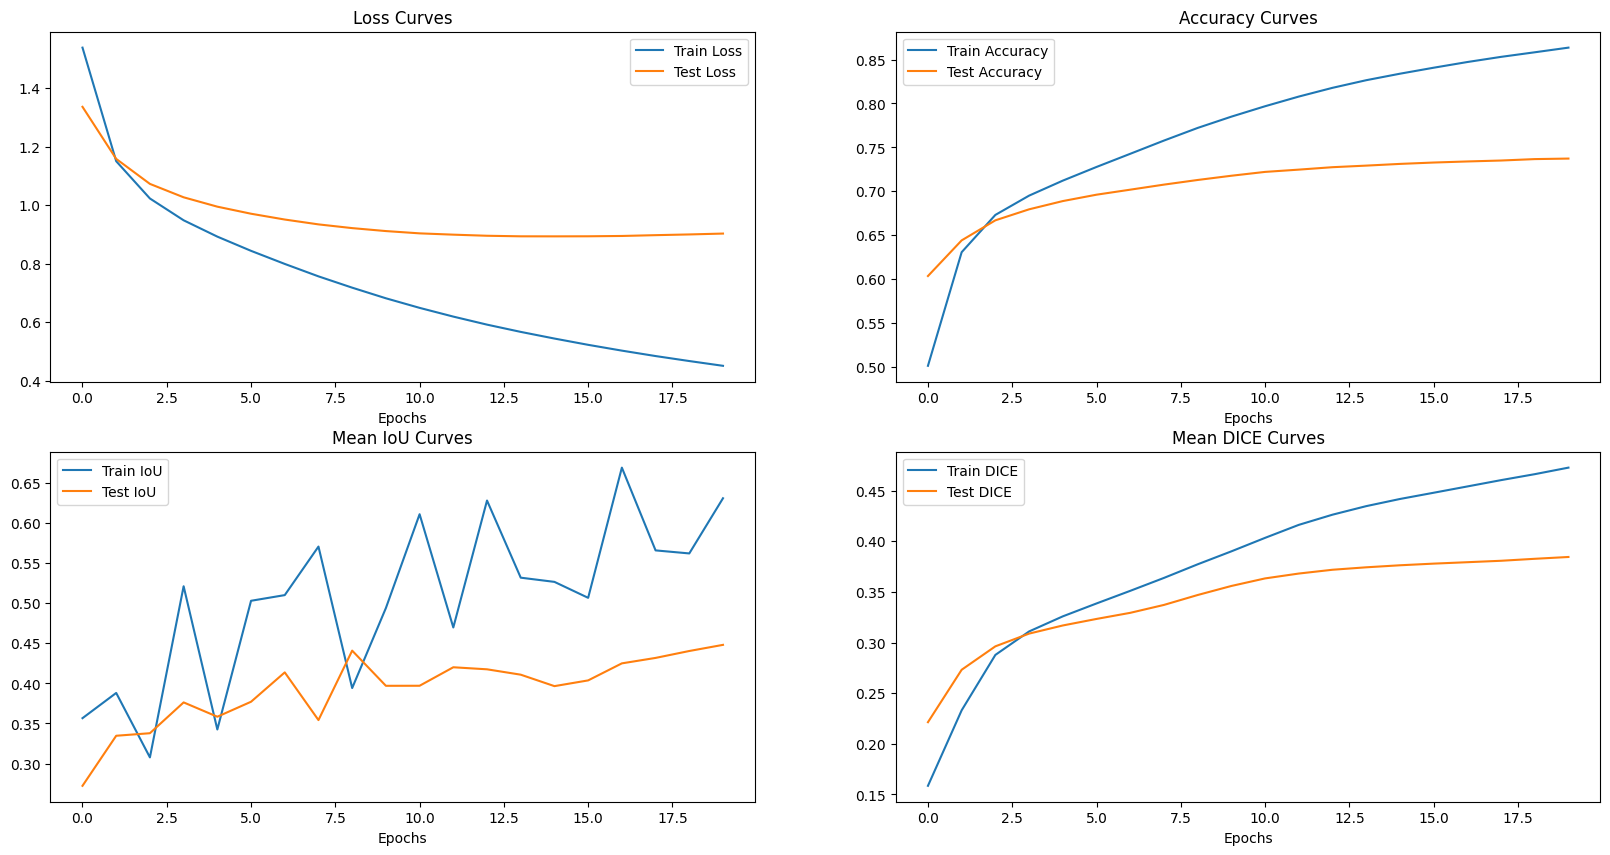

In [26]:
def plot_performance_metrics(model_result: dict):
    epochs = range(len(model_result['train_loss']))
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, model_result['train_loss'], label='Train Loss')
    plt.plot(epochs, model_result['test_loss'], label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, model_result['train_acc'], label='Train Accuracy')
    plt.plot(epochs, model_result['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, model_result['train_iou_mean'], label='Train IoU')
    plt.plot(epochs, model_result['test_iou_mean'], label='Test IoU')
    plt.title('Mean IoU Curves')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, model_result['train_dice_mean'], label='Train DICE')
    plt.plot(epochs, model_result['test_dice_mean'], label='Test DICE')
    plt.title('Mean DICE Curves')
    plt.xlabel('Epochs')
    plt.legend();


plot_performance_metrics(model_result=model0_result)

In [27]:
# Creating function to convert onehot prediction into an image
def onehot_to_rgbmask(
        onehot_mask: np.ndarray,
        colormap: list,
        save_mask: bool = False,
        filename: str = 'mask.png',
        verbose: bool = True
):
    onehot_mask = np.array(onehot_mask)
    assert len(onehot_mask.shape) == 4  # Shape of the mask
    assert onehot_mask.shape[0] == 1  # One image in a batch
    assert len(colormap) == onehot_mask.shape[1]  # Total number of classes

    # Getting the class with the highest probability
    onehot_mask = np.argmax(onehot_mask, axis=1)

    # Creating a array to fill the output
    output = np.zeros(onehot_mask.shape[1:] + (3,))

    # Changing the dimension to (HWC)
    onehot_mask = np.transpose(onehot_mask, (1, 2, 0))

    for label, color in enumerate(colormap):
        if label < len(colormap):
            # Matching the onehot label with the class label
            # Then replacing the values with the RGB color values.
            output[np.all(np.equal(onehot_mask, label), axis=-1)] = color

    output = output.astype(np.uint8) * 255

    if save_mask:
        mask_img = Image.fromarray(output)
        mask_img.save(filename)

    if save_mask and verbose:
        print('[INFO] Onehot encoded mask has been converted into RGB mask.')
        print(f'[INFO] RGB mask is been saved to the location: "{filename}".')
    elif verbose:
        print('[INFO] Onehot encoded mask has been converted into RGB mask.')

    return output


def predict_and_save(
        model: torch.nn.Module,
        pred_transform,
        data_path: str,
        colormap: list,
        device: torch.device,
        save_pred: bool = True,
        save_dir: str = 'pred_result/',
        verbose: bool = False
):
    # Checking the data path is a file or dir
    if os.path.isdir(data_path):
        filepath_list = get_sorted_image_paths(data_path)
    elif os.path.isfile(data_path):
        filepath_list = [data_path]
    else:
        raise Exception('[ERROR] Only file or directory is allowed for data path.')

    pred_mask = []

    for fpath in tqdm(filepath_list):
        # Reading and transforming the image
        image = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
        aug = pred_transform(image=image)
        image = aug['image'].unsqueeze(0).to(device)

        # Predicting using the model
        model.eval()
        with torch.inference_mode():
            pred = torch.softmax(model(image), 1)

            assert len(colormap) == pred.shape[1]  # Checking classes size
            if not os.path.exists(save_dir):  # Checking save dir
                os.makedirs(save_dir)
            pred_fname = os.path.join(
                save_dir, 'pred_' + fpath.split('/')[-1] \
                          .split('.')[0] + '.bmp'
            )

            # Converting the prediction into RGB mask and saving the mask
            pred_mask.append(
                onehot_to_rgbmask(
                    onehot_mask=pred.cpu().detach().numpy(),
                    colormap=colormap,
                    save_mask=save_pred,
                    filename=pred_fname,
                    verbose=verbose
                )
            )
    if save_pred and not verbose:
        print(f'[INFO] All the prediction is been saved to location: "{save_dir}"')

    return np.asarray(pred_mask)

In [28]:
# Predicting all the val/test set and saving the prediction
pred_result = predict_and_save(
    model=model,
    pred_transform=val_transform,
    data_path=VAL_IMG_DIR,
    colormap=COLORMAP_LIST,
    device=DEVICE
)

  0%|          | 0/305 [00:00<?, ?it/s]

[INFO] All the prediction is been saved to location: "pred_result/"


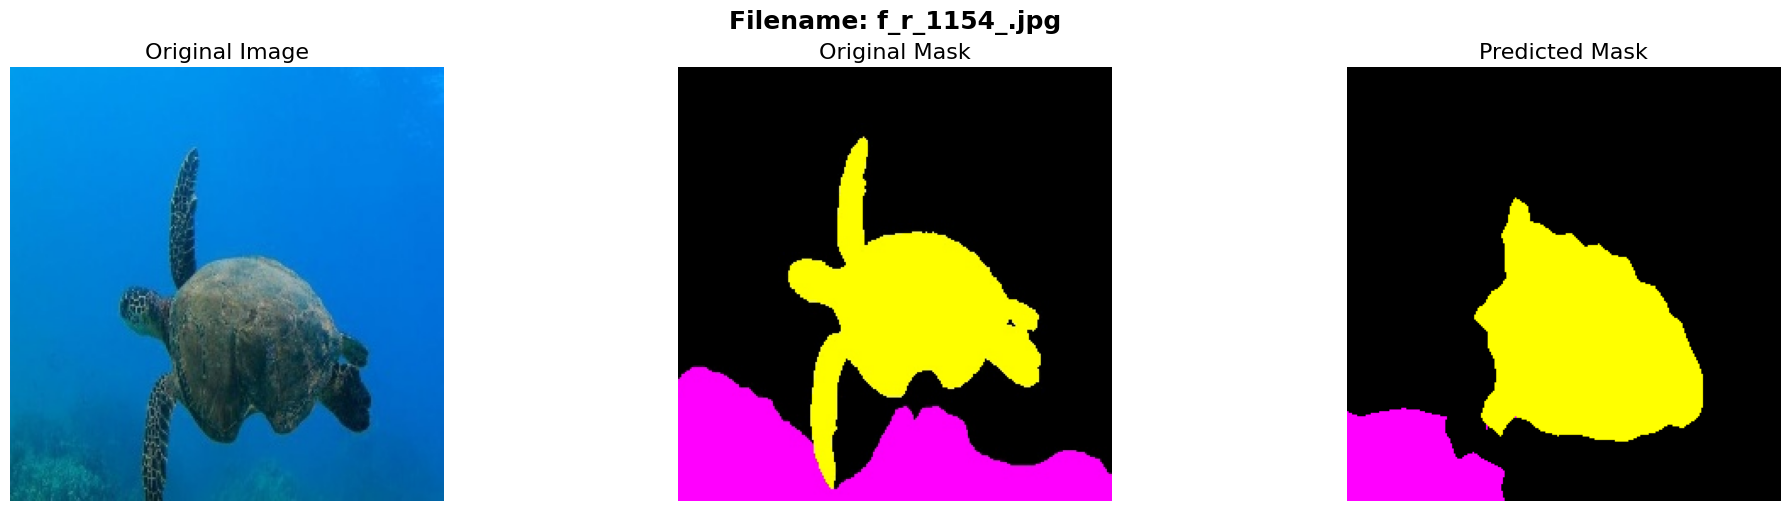

In [35]:
# Randomly comparing validation/testing images, masks and predicted masks
val_filelist = get_sorted_image_paths(VAL_IMG_DIR, False)
rand_sample = random.sample(val_filelist, 1)[0]
plt.figure(figsize=(20, 5), layout='constrained')

plt.suptitle(f'Filename: {rand_sample}', fontweight='bold', fontsize=18)
plt.subplot(1, 3, 1)
image = plt.imread(os.path.join(VAL_IMG_DIR, rand_sample))
plt.imshow(image)
plt.title('Original Image', fontsize=16)
plt.axis(False)

plt.subplot(1, 3, 2)
mask = plt.imread(
    os.path.join(
        VAL_MASK_DIR,
        rand_sample.replace('.jpg', '.bmp')
    )
)
plt.imshow(mask)
plt.title('Original Mask', fontsize=16)
plt.axis(False)

plt.subplot(1, 3, 3)
image = plt.imread(
    os.path.join(
        'pred_result',
        'pred_' + rand_sample.replace('.jpg', '.bmp')
    )
)
plt.imshow(image)
plt.title('Predicted Mask', fontsize=16)
plt.axis(False);